In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import RepeatVector

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from scipy.stats import describe
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
from time import gmtime, strftime
from tensorflow.keras.callbacks import TensorBoard
import re

# Needed to run only once
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/am/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def lookup_word2id(word):
    try:
        return word2id[word]
    except KeyError:
        return word2id["UNK"]


In [3]:
def load_glove_vectors(glove_file, word2id, embed_size):
    embedding = np.zeros((len(word2id), embed_size))
    fglove = open(glove_file, "rb")
    for line in fglove:
        cols = line.strip().split()
        word = cols[0].decode('utf-8')
        if embed_size == 0:
            embed_size = len(cols) - 1
        if word in word2id:
            vec = np.array([float(v) for v in cols[1:]])
        embedding[lookup_word2id(word)] = vec
    embedding[word2id["PAD"]] = np.zeros((embed_size))
    embedding[word2id["UNK"]] = np.random.uniform(-1, 1, embed_size)
    return embedding


In [4]:
def sentence_generator(X, embeddings, batch_size):
    while True:
        # loop once per epoch
        num_recs = X.shape[0]
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            sids = indices[bid * batch_size: (bid + 1) * batch_size]
            Xbatch = embeddings[X[sids, :]]
            yield Xbatch, Xbatch

In [5]:
def compute_cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))


In [6]:
DATA_DIR = "data"

def is_number(n):
    temp = re.sub("[.,-/]", "",n)
    return temp.isdigit()

# parsing sentences and building vocabulary
word_freqs = collections.Counter()
ftext = open(os.path.join(DATA_DIR, "text.tsv"), "r")
sents = []
sent_lens = []
for line in ftext:
    docid, text = line.strip().split("\t")
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if is_number(word):
                word = "9"
            word = word.lower()
            word_freqs[word] += 1
        sents.append(sent)
        sent_lens.append(len(sent))
ftext.close()

In [7]:
print("Total number of sentences are: {:d} ".format(len(sents)))
print ("Sentence distribution min {:d}, max {:d} , mean {:3f}, median {:3f}".
      format(np.min(sent_lens), np.max(sent_lens), np.mean(sent_lens), np.median(sent_lens)))
print("Vocab size (full) {:d}".format(len(word_freqs)))


Total number of sentences are: 131545 
Sentence distribution min 1, max 2434 , mean 120.525052, median 115.000000
Vocab size (full) 50743


In [8]:
VOCAB_SIZE = 5000
EMBED_SIZE = 50
LATENT_SIZE = 512
SEQUENCE_LEN = 50

BATCH_SIZE = 64
NUM_EPOCHS = 20


In [9]:
# word2id = collections.defaultdict(lambda: 1)
word2id = {}
word2id["PAD"] = 0
word2id["UNK"] = 1
for v, (k, _) in enumerate(word_freqs.most_common(VOCAB_SIZE - 2)):
    word2id[k] = v + 2
id2word = {v: k for k, v in word2id.items()}

print("vocabulary sizes:", len(word2id), len(id2word))

sent_wids = [[lookup_word2id(w) for w in s.split()] for s in sents]
sent_wids = sequence.pad_sequences(sent_wids, SEQUENCE_LEN)

# load glove vectors into weight matrix
embeddings = load_glove_vectors(os.path.join(
    DATA_DIR, "glove.6B.{:d}d.txt".format(EMBED_SIZE)), word2id, EMBED_SIZE)
print(embeddings.shape)

# split sentences into training and test
train_size = 0.7
Xtrain, Xtest = train_test_split(sent_wids, train_size=train_size)
print("number of sentences: ", len(sent_wids))
print(Xtrain.shape, Xtest.shape)

vocabulary sizes: 5000 5000
(5000, 50)
number of sentences:  131545
(92081, 50) (39464, 50)


/home/am/anaconda3/envs/tf2p0alpha/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [10]:
# define training and test generators
train_gen = sentence_generator(Xtrain, embeddings, BATCH_SIZE)
test_gen = sentence_generator(Xtest, embeddings, BATCH_SIZE)

In [11]:
# define autoencoder network
inputs = Input(shape=(SEQUENCE_LEN, EMBED_SIZE), name="input")
encoded = Bidirectional(LSTM(LATENT_SIZE), merge_mode="sum",
                        name="encoder_lstm")(inputs)
decoded = RepeatVector(SEQUENCE_LEN, name="repeater")(encoded)
decoded = Bidirectional(LSTM(EMBED_SIZE, return_sequences=True),
                        merge_mode="sum",
                        name="decoder_lstm")(decoded)

autoencoder = Model(inputs, decoded)

#tensorboard = make_tensorboard(set_dir_name='rnn')

W0827 08:36:53.456710 140327285733120 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9fe809f588>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0827 08:36:53.468909 140327285733120 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9fe655a390>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0827 08:36:54.271372 140327285733120 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9fe5f31f28>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0827 08:36:54.273263 140327285733120 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f9fe64fd128>: Note that this layer is not optimized for performance. Please use tf.keras.laye

In [12]:
autoencoder.compile(optimizer="adam", loss="mse")

# train
num_train_steps = len(Xtrain) // BATCH_SIZE
num_test_steps = len(Xtest) // BATCH_SIZE
#checkpoint = ModelCheckpoint(
#   filepath=os.path.join(DATA_DIR, "sent-thoughts-autoencoder.h5"),
#    save_best_only=True)
history = autoencoder.fit_generator(train_gen,
                                    steps_per_epoch=num_train_steps,
                                    epochs=NUM_EPOCHS,
                                    validation_data=test_gen,
                                    validation_steps=num_test_steps) 
                                    #callbacks=[checkpoint, tensorboard])


Epoch 1/20
1438/1438 [==============================] - 58s 40ms/step - loss: 0.1161 - val_loss: 0.1097
Epoch 2/20
1438/1438 [==============================] - 59s 41ms/step - loss: 0.1070 - val_loss: 0.1051
Epoch 3/20
1438/1438 [==============================] - 59s 41ms/step - loss: 0.1030 - val_loss: 0.1013
Epoch 4/20
1438/1438 [==============================] - 59s 41ms/step - loss: 0.0991 - val_loss: 0.0977
Epoch 5/20
1438/1438 [==============================] - 59s 41ms/step - loss: 0.0954 - val_loss: 0.0943
Epoch 6/20
1438/1438 [==============================] - 59s 41ms/step - loss: 0.0927 - val_loss: 0.0923
Epoch 7/20
1438/1438 [==============================] - 59s 41ms/step - loss: 0.0910 - val_loss: 0.0910
Epoch 8/20
1438/1438 [==============================] - 59s 41ms/step - loss: 0.0896 - val_loss: 0.0895
Epoch 9/20
1438/1438 [==============================] - 59s 41ms/step - loss: 0.0884 - val_loss: 0.0886
Epoch 10/20
1438/1438 [==============================] - 59s 41m

In [13]:
# collect autoencoder predictions for test set
test_inputs, test_labels = next(test_gen)
preds = autoencoder.predict(test_inputs)

# extract encoder part from autoencoder
encoder = Model(autoencoder.input,
                autoencoder.get_layer("encoder_lstm").output)
# encoder.summary()


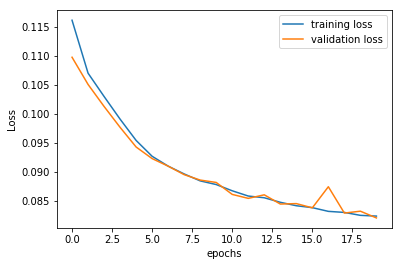

In [14]:
plt.plot(history.history["loss"], label = "training loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

In [15]:
# compute difference between vector produced by original and autoencoded
k = 500
cosims = np.zeros((k))
i = 0
for bid in range(num_test_steps):
    xtest, ytest = next(test_gen)
    ytest_ = autoencoder.predict(xtest)
    Xvec = encoder.predict(xtest)
    Yvec = encoder.predict(ytest_)
    for rid in range(Xvec.shape[0]):
        if i >= k:
            break
        cosims[i] = compute_cosine_similarity(Xvec[rid], Yvec[rid])
        if i <= 10:
            print(cosims[i])
        i += 1
    if i >= k:
        break

0.984686553478241
0.9815746545791626
0.9793671369552612
0.9805112481117249
0.9630994200706482
0.9790557622909546
0.9893233180046082
0.9869443774223328
0.9665998220443726
0.9893233180046082
0.9829331040382385


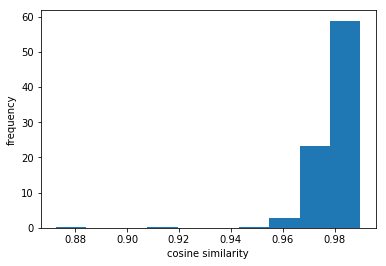

In [16]:
plt.hist(cosims, bins=10, density=True)
plt.xlabel("cosine similarity")
plt.ylabel("frequency")
plt.show()